### Keypoints
- This notebook is based on [llc-bot](https://github.com/rabernat/poseidon-bot/blob/30a55a0d795391f0508a0c45ce57f87026c46ef0/llcbot.ipynb)
- learn how to make geo-map using specific projection
- learn the `.mean('time')`
- feel the dask speed

In [1]:
!pip install cmocean

In [2]:
import random
import os
import xarray as xr
import numpy as np
import xgcm 
from matplotlib import pyplot as plt
from matplotlib import image
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
year = datetime.datetime.now().year
%matplotlib inline

In [3]:
import dask
dask.config.set({"logging.distributed": "warning"})
from dask_gateway import GatewayCluster
from dask.distributed import Client
cluster = GatewayCluster()
cluster.scale(5) # worker number
client = Client(cluster)
cluster

In [4]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")
list(cat)

['LLC4320_grid',
 'LLC4320_SST',
 'LLC4320_SSS',
 'LLC4320_SSH',
 'LLC4320_SSU',
 'LLC4320_SSV']

In [5]:
grid_full = cat.LLC4320_grid.to_dask()
grid_full

<xarray.Dataset>
Dimensions:  (face: 13, j: 4320, i: 4320, k_p1: 2, j_g: 4320, i_g: 4320,
              time: 9030)
Coordinates: (12/37)
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    ...       ...
    k_u      int64 ...
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

## Here is the setting of faces
![](./figs/index.png)

In [6]:
selector = dict(time=0, face=5,i=slice(3000, 4000, None), j=slice(500, 1500, None),i_g=slice(3000, 4000, None), j_g=slice(500, 1500, None))

In [7]:
grid_ds = grid_full.isel(**selector)
grid_ds

<xarray.Dataset>
Dimensions:  (j: 1000, i: 1000, k_p1: 2, j_g: 1000, i_g: 1000)
Coordinates: (12/37)
    CS       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    ...       ...
    k_u      int64 ...
    rA       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    time     datetime64[ns] 2011-09-13
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

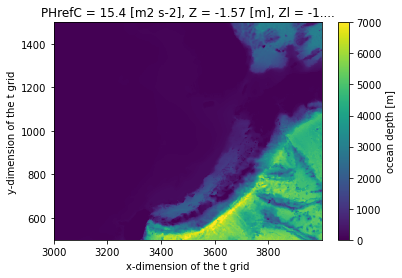

In [8]:
grid_ds.Depth.plot() # Check the area by ocean depth

In [9]:
sst = cat.LLC4320_SST(chunks=False).to_dask().isel(time=0, face=5, i=slice(3000, 4000, None), j=slice(500, 1500, None))
ssh = cat.LLC4320_SSH(chunks=False).to_dask().isel(time=0, face=5, i=slice(3000, 4000, None), j=slice(500, 1500, None))

# sss has some extra metadata
sss = cat.LLC4320_SSS(chunks=False).to_dask().isel(time=0, face=5, i=slice(3000, 4000, None), j=slice(500, 1500, None))[['SSS']].reset_coords(drop=True)

u = cat.LLC4320_SSU(chunks=False).to_dask().isel(time=slice(0,24), face=5, i_g=slice(3000, 4000, None), j=slice(500, 1500, None)).mean('time') # E-W velocity 
v = cat.LLC4320_SSV(chunks=False).to_dask().isel(time=slice(0,24), face=5, i=slice(3000, 4000, None), j_g=slice(500, 1500, None)).mean('time') # N-S velocity

ssh


<xarray.Dataset>
Dimensions:  (j: 1000, i: 1000)
Coordinates:
    face     int64 5
  * i        (i) int64 3000 3001 3002 3003 3004 ... 3995 3996 3997 3998 3999
  * j        (j) int64 500 501 502 503 504 505 ... 1494 1495 1496 1497 1498 1499
    time     datetime64[ns] 2011-09-13
Data variables:
    Eta      (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [10]:
ds = xr.merge([grid_ds, ssh, sst, sss, u, v])
ds

<xarray.Dataset>
Dimensions:  (j: 1000, i: 1000, k_p1: 2, j_g: 1000, i_g: 1000)
Coordinates: (12/37)
    CS       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    ...       ...
    k_u      int64 ...
    rA       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    time     datetime64[ns] 2011-09-13
Data variables:
    Eta      (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    SST      (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    SSS      (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    U        (j, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    V        (j_g, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [11]:
# vertical coordiantes are not helpful
ds = ds.drop(['Z', 'Zl', 'Zp1', 'Zu', 'k', 'k_l', 'k_p1', 'PHrefF', 'drC'])
ds

<xarray.Dataset>
Dimensions:  (j: 1000, i: 1000, j_g: 1000, i_g: 1000)
Coordinates: (12/28)
    CS       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    PHrefC   float32 ...
    SN       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    ...       ...
    k_u      int64 ...
    rA       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    time     datetime64[ns] 2011-09-13
Data variables:
    Eta      (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    SST      (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    SSS      (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    U        (j, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    V        (j_g, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

## Prepare the map

In [12]:
# fix wraparound lons

def maybe_wrap_lon(lon):
    if abs(lon.min() - lon.max()) < 180:
        return lon
    else:
        return lon.where(lon > 0, other=(lon + 360)) # DataArray.where(cond, other=<NA>, drop=False)
    
ds.coords['XC'] = maybe_wrap_lon(ds.XC)
ds.coords['XG'] = maybe_wrap_lon(ds.XG)

In [13]:
grid = xgcm.Grid(ds, periodic=False)
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center

In [14]:
ds['eke'] = 0.5 * (grid.interp(ds.U**2, 'X', boundary='extend')
             + grid.interp(ds.V**2, 'Y', boundary='extend'))

ds['zeta'] = 1e4 * (-grid.diff(ds.U * ds.dxC, 'Y', boundary='extend') +
                    grid.diff(ds.V * ds.dyC, 'X', boundary='extend'))/ds.rAz

ds['div'] = (grid.diff(ds.U * ds.dxC, 'X', boundary='extend') +
             grid.diff(ds.V * ds.dyC, 'Y', boundary='extend'))/ds.rA

In [15]:
ds

<xarray.Dataset>
Dimensions:  (j: 1000, i: 1000, j_g: 1000, i_g: 1000)
Coordinates: (12/28)
    CS       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    PHrefC   float32 ...
    SN       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    ...       ...
    k_u      int64 ...
    rA       (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    time     datetime64[ns] 2011-09-13
Data variables:
    Eta      (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    SST      (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    SSS      (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    U        (j, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    V        (j_g, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    eke      (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    zeta     (j_g, i_g) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    div      (j, i) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [16]:
# fix some metadata
ds.zeta.attrs['units'] = r'$10^{-4}$ s$^{-1}$'
ds.zeta.attrs['long_name'] = 'Vorticity'

ds.SST.attrs['units'] = r'$^\circ$C'
ds.SST.attrs['long_name'] = 'Sea Surface Temperature'

ds.SSS.attrs['units'] = r'PSU'
ds.SSS.attrs['long_name'] = 'Sea Surface Salinity'

ds.Eta.attrs['units'] = r'm'
ds.Eta.attrs['long_name'] = 'Sea Surface Height'

In [17]:
central_lon = ds.XC.mean().values.item()
central_lat = ds.YC.mean().values.item()
print(central_lon )
print(central_lat)

lon_min = ds.XC.min().values.item()
lon_max = ds.XC.max().values.item()
lon_range = lon_max - lon_min

lat_min = ds.YC.min().values.item()
lat_max = ds.YC.max().values.item()
lat_range = lat_max - lat_min


124.9167709350586
31.22719955444336


In [18]:
proj = ccrs.Orthographic(central_longitude=central_lon,
                         central_latitude=central_lat) # map projection

date_str = np.datetime_as_string(ds.time.values, timezone='UTC', unit='m')

location = f'{central_lon:3.1f}, {central_lat:3.1f} | {date_str}'
print(location)

124.9, 31.2 | 2011-09-13T00:00Z


In [19]:
# tiles near equator are square
# towards pole, both dimensions contract
scale_lon = 2 + 0.75 * abs(np.deg2rad(central_lat))
scale_lat = 2 + 0.3 * abs(np.deg2rad(central_lat))

print(scale_lon, scale_lat)

extent = [central_lon - lon_range/scale_lon, central_lon + lon_range/scale_lon,
          central_lat - lat_range/scale_lat, central_lat + lat_range/scale_lat]

2.4087630863017573 2.163505234520703


In [31]:
plt.rcParams['font.size'] = 16

# img_url = "https://raw.githubusercontent.com/pangeo-data/branding/master/logo/v_small_pangeo_logo.png"
# logo_img = image.imread(img_url)

def plot(da, clip_extent=True, **kwargs):
    xdim = 'XC' if 'i' in da.dims else 'XG'
    ydim = 'YC' if 'j' in da.dims else 'YG'
    
    fig = plt.figure(figsize=(13, 10))
    ax = fig.add_axes([0, 0.02, 1, 0.91],
                      projection=ccrs.Orthographic(central_lon, central_lat))
    ax.background_patch.set_facecolor('0.6')
    
    # ax0 = plt.axes(projection=rotated_crs)
    # ax0.set_extent([-6, 1, 47.5, 51.5], crs=ccrs.PlateCarree())
    # ax0.add_feature(cfeature.LAND.with_scale('10m'))
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)    
    
    
    if clip_extent:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines()
    
    da.plot(ax=ax, x=xdim, y=ydim, transform=ccrs.PlateCarree(), **kwargs) # da 在这里出现
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    # ax.set_title(f'LLC4320 {da.long_name} | {location}')
    
    # logo_axis = fig.add_axes([0.81, 0.017, 0.12, 0.05])
    # fig.text(0.815, 0.1, f'© Ryan Abernathey\n{year} CC BY',
    #          fontdict={'size': 11})
    # logo_axis.imshow(logo_img, interpolation='hanning')
    # logo_axis.axis('off')


/tmp/ipykernel_872/224983251.py:13: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  ax.background_patch.set_facecolor('0.6')


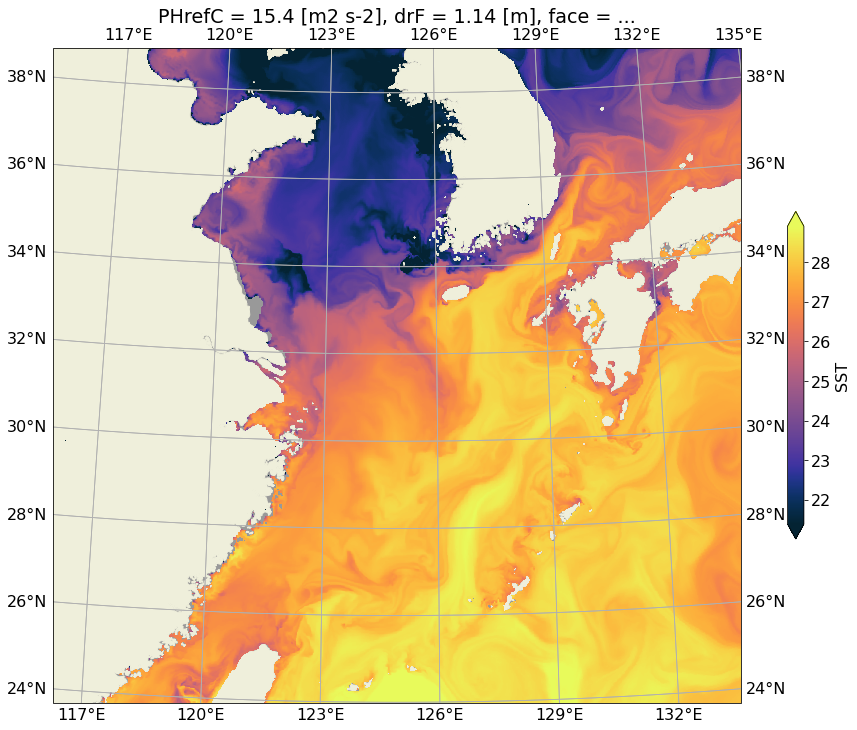

In [123]:
plot(ds.SST, center=False, robust=True, cmap=cmocean.cm.thermal,
     cbar_kwargs={'shrink': 0.5})
# plot(ds.SST)
# plt.savefig('SST.png')

/tmp/ipykernel_872/224983251.py:13: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  ax.background_patch.set_facecolor('0.6')


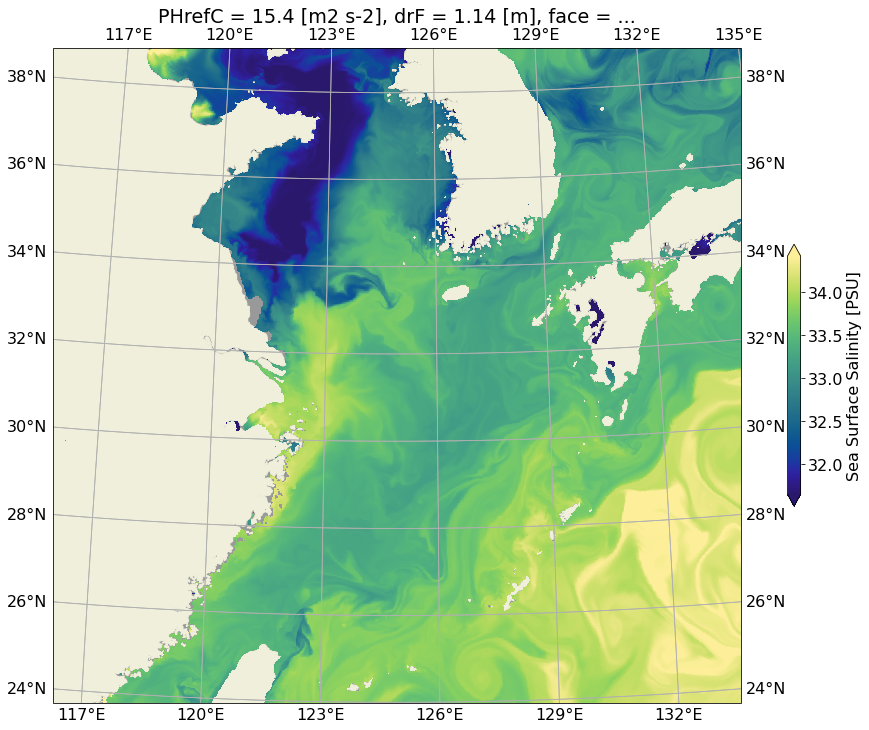

In [95]:
plot(ds.SSS, center=False, robust=True, cmap=cmocean.cm.haline,
     cbar_kwargs={'shrink': 0.4})
plt.savefig('SSS.png')

/tmp/ipykernel_872/224983251.py:13: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  ax.background_patch.set_facecolor('0.6')


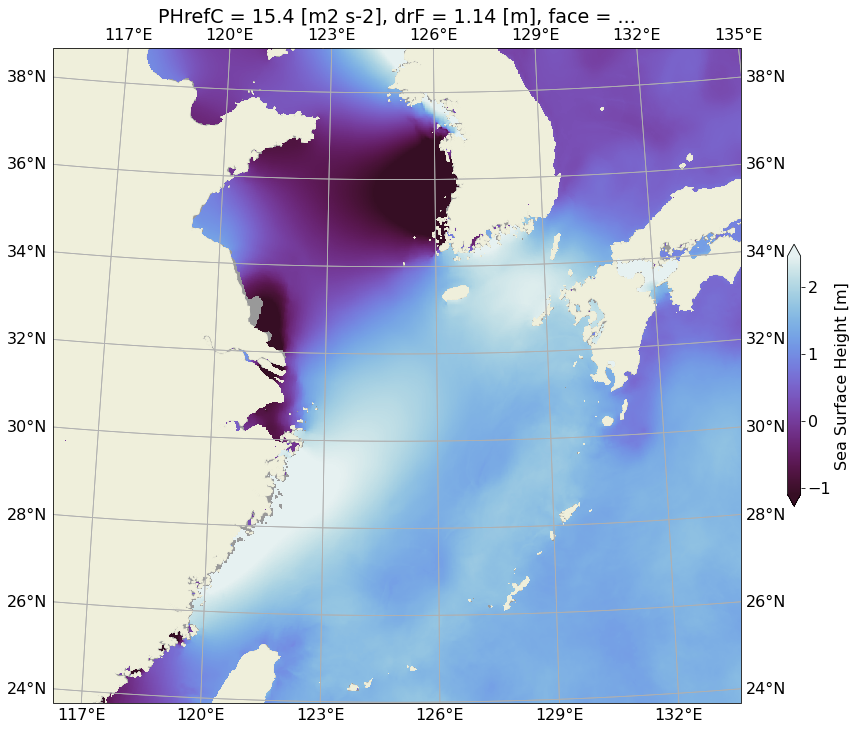

In [96]:
plot(ds.Eta, center=False, robust=True, cmap=cmocean.cm.dense_r,
     cbar_kwargs={'shrink': 0.4})
plt.savefig('SSH.png')

/tmp/ipykernel_402/3955710974.py:13: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  ax.background_patch.set_facecolor('0.6')


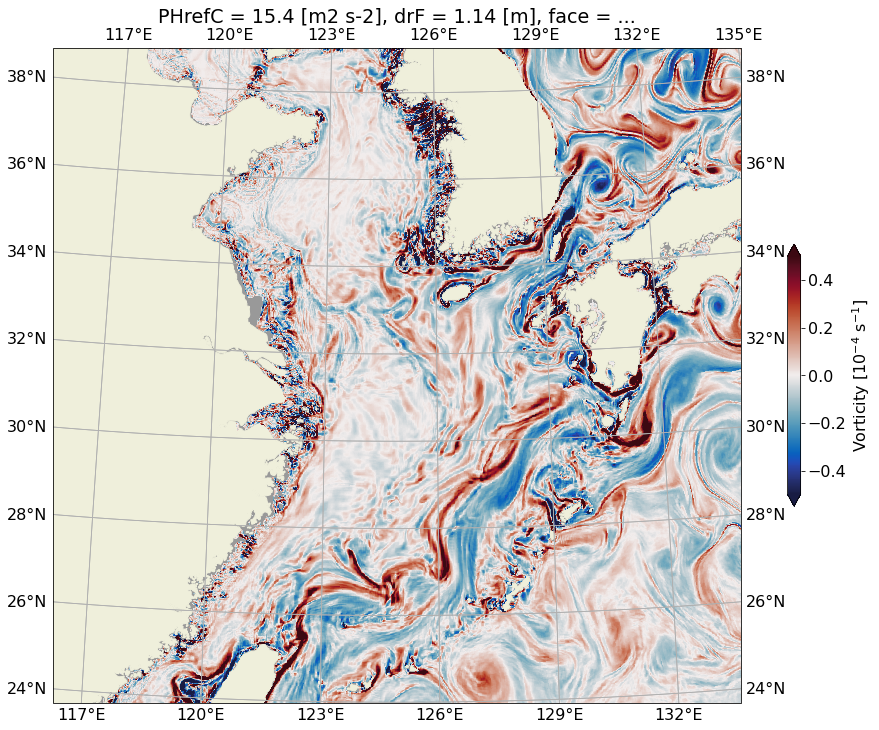

In [32]:
plot(ds.zeta, robust=True, cmap=cmocean.cm.balance,vmin=-0.5, vmax=0.5 , cbar_kwargs={'shrink': 0.4})
# plot(ds.zeta,  cmap=cmocean.cm.balance,vmin=-0.5, vmax=0.5 )
# ds.zeta.plot()
plt.savefig('Vort.pdf')

In [22]:
ds.zeta.load()

<xarray.DataArray 'zeta' (j_g: 1000, i_g: 1000)>
array([[        nan,         nan,         nan, ...,  0.08324866,
         0.08168085,  0.08049278],
       [        nan,         nan,         nan, ...,  0.13954519,
         0.14342225,  0.13961515],
       [        nan,         nan,         nan, ...,  0.13254716,
         0.14062943,  0.14113642],
       ...,
       [        nan,         nan,         nan, ...,  0.01009367,
         0.0026559 , -0.00743691],
       [        nan,         nan,         nan, ..., -0.01001264,
        -0.01870865, -0.02960504],
       [        nan,         nan,         nan, ..., -0.03133778,
        -0.03716999, -0.04417459]], dtype=float32)
Coordinates:
    PHrefC   float32 15.4
    XG       (j_g, i_g) float32 114.5 114.5 114.5 114.6 ... 135.3 135.3 135.3
    YG       (j_g, i_g) float32 22.82 22.82 22.82 22.82 ... 39.16 39.16 39.16
    drF      float32 1.14
    face     int64 5
  * i_g      (i_g) int64 3000 3001 3002 3003 3004 ... 3995 3996 3997 3998 3999
    iter     int64 10368
  * j_g      (j_g) int64 500 501 502 503 504 505 ... 1495 1496 1497 1498 1499
    k_u      int64 1
    rAz      (j_g, i_g) float32 4.189e+06 4.189e+06 ... 2.985e+06 2.985e+06
    time     datetime64[ns] 2011-09-13
Attributes:
    units:      $10^{-4}$ s$^{-1}$
    long_name:  Vorticity

In [122]:
ds.zeta.reset_coords()[["zeta","XG","YG"]].to_netcdf("my.nc")